# Part 1: Single subject classification (subject 1)
## Import required libraries

In [193]:
# Import Required Libraries
import os
import zipfile
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import numpy as np
import seaborn as sns
sns.set()
from scipy.io import loadmat
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

In [194]:
from scripts import *

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and extract data

In [195]:
# Load and Extract Data

# Define the path to the zip file and the extraction directory
zip_file_path = '../data/s2.zip'
extraction_dir = '../data/'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

# Define the paths to the .mat files
mat_file_path = os.path.join(extraction_dir, 'S2_A1_E1.mat')
mat_file_path_e2 = os.path.join(extraction_dir, 'S2_A1_E2.mat')
mat_file_path_e3 = os.path.join(extraction_dir, 'S2_A1_E3.mat')

# Delete the S1_A1_E2.mat and S1_A1_E3.mat files
if os.path.exists(mat_file_path_e2):
    os.remove(mat_file_path_e2)
if os.path.exists(mat_file_path_e3):
    os.remove(mat_file_path_e3)

# Load the .mat file using scipy.io.loadmat
mat_data = loadmat(mat_file_path)

# Extract the data and labels
data = mat_data['emg']
stimulus = mat_data['restimulus'] # Type of movement that is being performed
repetition = mat_data['rerepetition'] # Number of times the movement has been repeated

## Exploration of the data

In [196]:

# Print the shape of the data and labels
print("EMG:", data.shape)
print("Stimulus:", stimulus.shape)
print("Repetition:", repetition.shape)
print(f"There are {data.shape[0]} timepoints and {data.shape[1]} channels.")

EMG: (100686, 10)
Stimulus: (100686, 1)
Repetition: (100686, 1)
There are 100686 timepoints and 10 channels.


In [197]:
n_stimuli = len(np.unique(stimulus)) - 1 # -1 because 0 is the resting condition
n_repetitions = len(np.unique(repetition)) - 1 # -1 because 0 is not a repetition
print(f'There are {n_stimuli} types of movement and {n_repetitions} repetitions.')

There are 12 types of movement and 10 repetitions.


In [198]:
# How many samples (or timesteps) has each trial?
n_samples = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx  =np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        n_samples[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))
n_samples

array([[307., 390., 262., 226., 418., 204., 196., 270., 306., 489.],
       [334., 323., 344., 309., 333., 376., 362., 307., 348., 339.],
       [465., 352., 450., 460., 436., 389., 323., 388., 383., 316.],
       [310., 402., 357., 396., 255., 333., 263., 369., 438., 471.],
       [516., 382., 425., 379., 463., 411., 387., 343., 286., 377.],
       [337., 319., 337., 368., 338., 336., 268., 354., 319., 313.],
       [428., 392., 341., 393., 421., 445., 342., 328., 329., 358.],
       [289., 372., 406., 397., 498., 336., 415., 328., 472., 405.],
       [384., 424., 371., 316., 280., 314., 342., 284., 307., 421.],
       [311., 296., 299., 296., 301., 246., 213., 317., 493., 221.],
       [352., 403., 338., 416., 330., 355., 313., 322., 329., 219.],
       [270., 330., 300., 387., 295., 204., 363., 267., 281., 329.]])

The time taken for each repetition of each movement can differ. 

## Visualization of EMG data

### Repetition 1 of stimulus 1
Visualization of a single trial usign moving average for detecting the envelope.

In [199]:
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

# Initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx  =np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = data[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0)


Text(0.5, 0.98, 'Envelopes of the EMG signal')

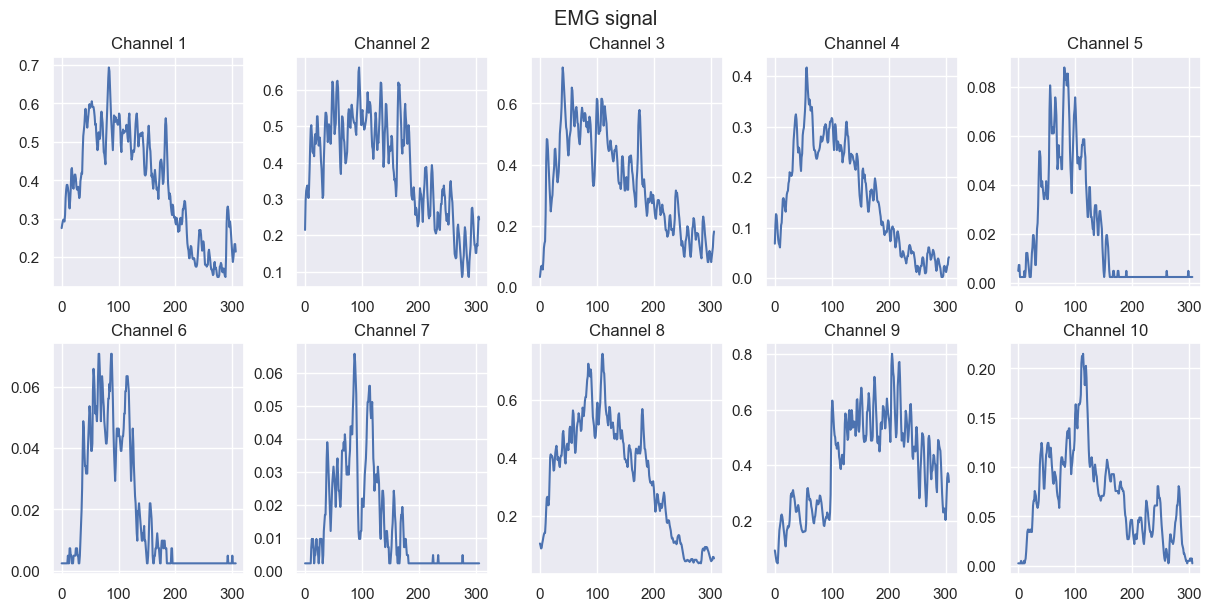

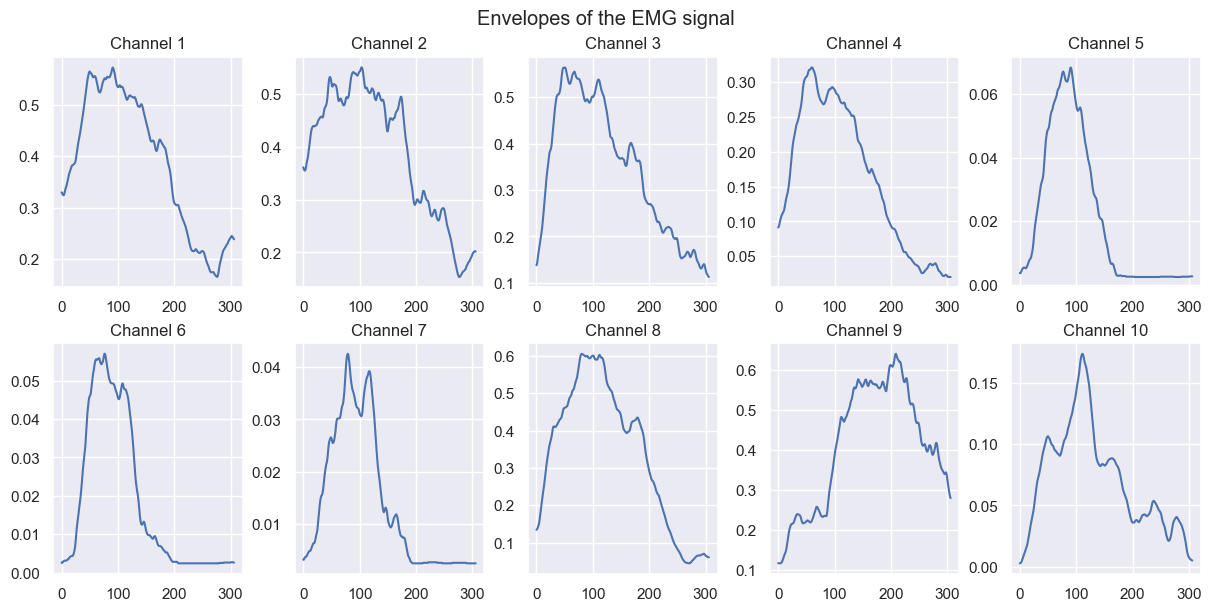

In [200]:

n_channels = data.shape[-1]

# EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout = True)
ax = ax.ravel()
for channel_idx in range(n_channels):
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f'Channel {channel_idx + 1}')
plt.suptitle("EMG signal")

# Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout = True)
ax = ax.ravel()
for channel_idx in range(n_channels):
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f'Channel {channel_idx + 1}')
plt.suptitle("Envelopes of the EMG signal")

To detect potential anomalies, we now want to plot all the channels with the same y axis:

Text(0.5, 0.98, 'Envelopes of the EMG signal')

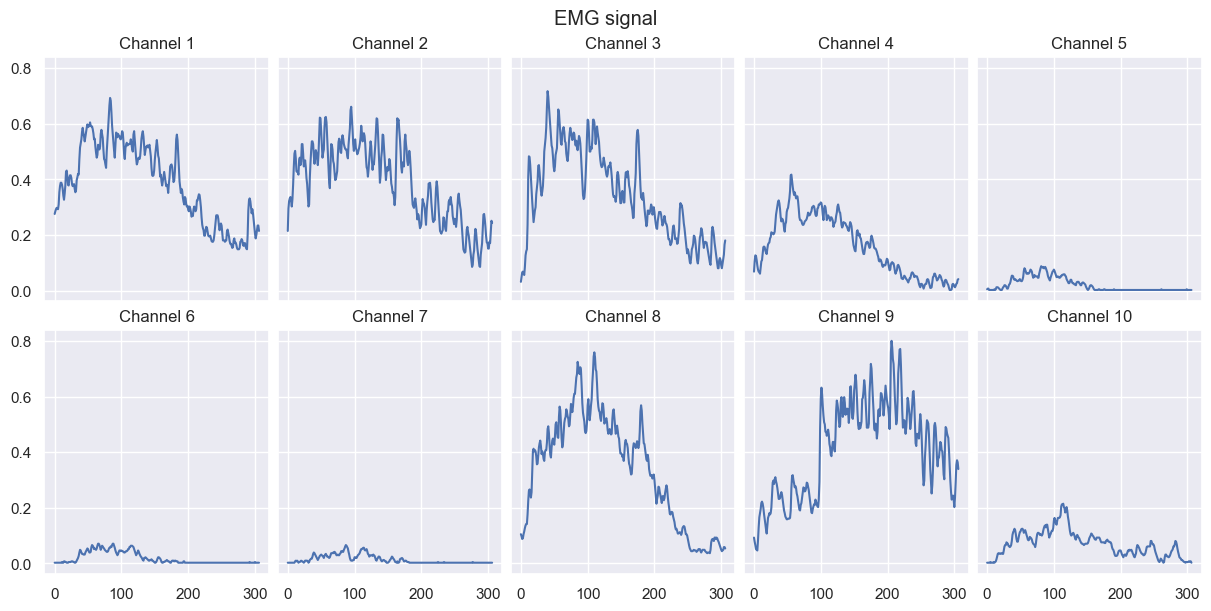

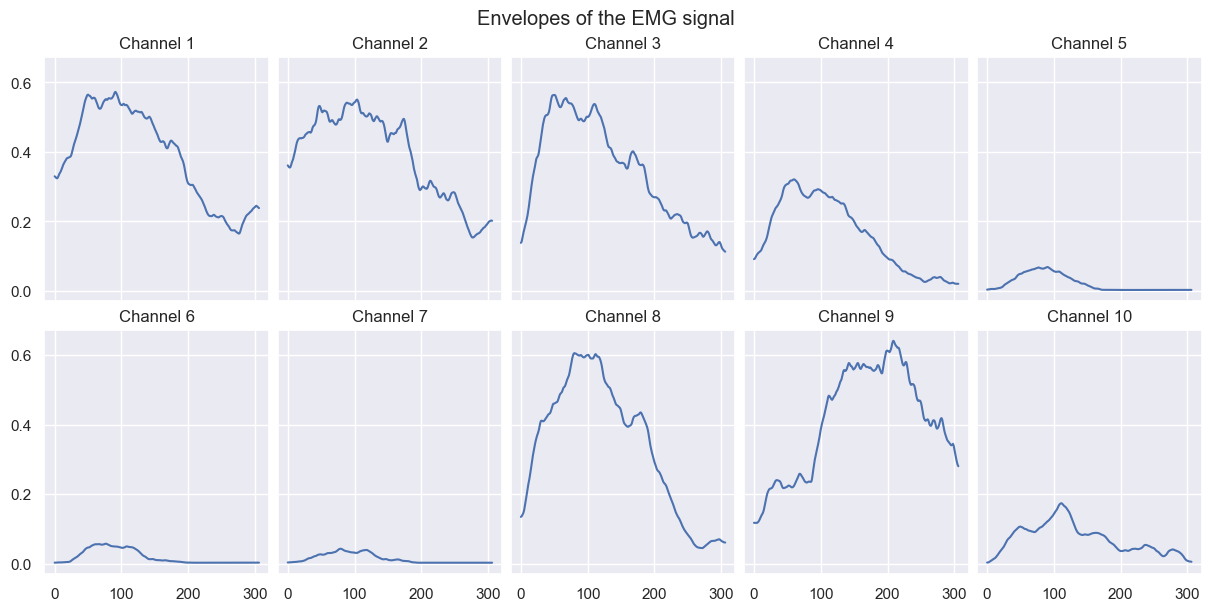

In [201]:
n_channels = data.shape[-1]

# EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout = True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(n_channels):
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f'Channel {channel_idx + 1}')
plt.suptitle("EMG signal")

# Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout = True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(n_channels):
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f'Channel {channel_idx + 1}')
plt.suptitle("Envelopes of the EMG signal")

The channels 1, 2, 3, 8 and 9 seem to have similar amplitudes, therefore we don't want to discard these channels, even though they might overpower the channels 5, 6 and 7.

### Visualization across repetitions
We will now check for the robustness of the signal, by plotting the 12 different stimuli

In [202]:
emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        # Mean across time
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0)

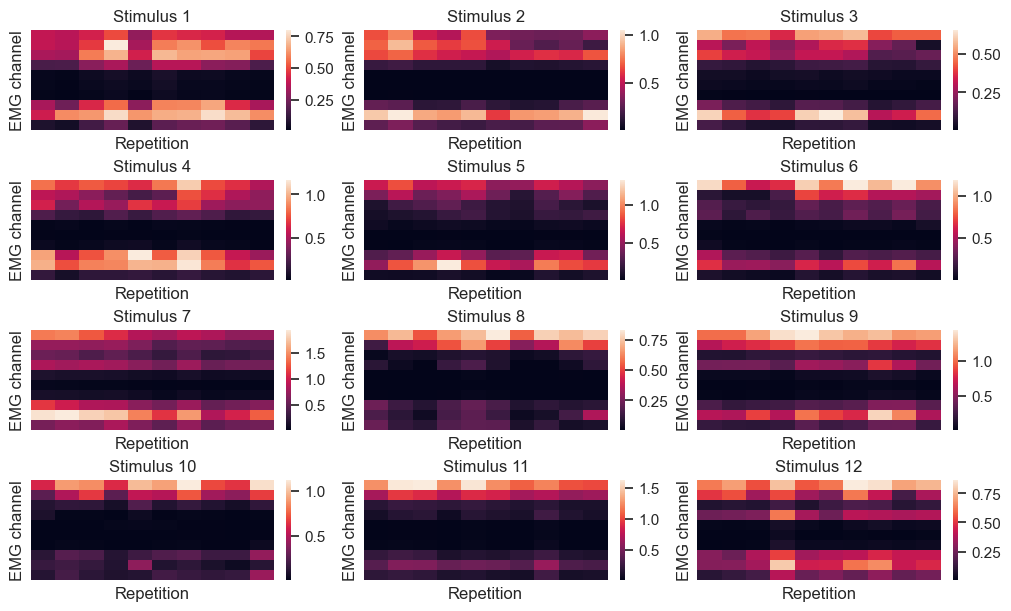

In [203]:
fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout = True, sharex=True, sharey=True)
ax = ax.ravel()
for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax = ax[stimuli_idx], xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

- Homogeneous by row: each channel is exposed to the same activity and captures similar muscular activity
- Variability across columns: Different muscles are not equally activated with each stimulus repetition (physiology + impedance)\\

Channels 5, 6 and 7 are overpowered by the other channels -> normalization
- Variability across stimuli: different stimuli cause activation in different muscle groups 

# Data Preprocessing
## Z-score normalization

In [204]:
# Z-score normalization for each channel
normalized_emg_data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

In [205]:
# TODO faire une fonction to avoid duplication of code
# Normalized data
n_emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
n_emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx  =np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1).flatten()
        n_emg_windows[stimuli_idx][repetition_idx] = normalized_emg_data[idx, :]
        n_emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(n_emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0)

n_emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        # Mean across time
        n_emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(n_emg_envelopes[stimuli_idx][repetition_idx], axis=0)

### Visualization after preprocessing

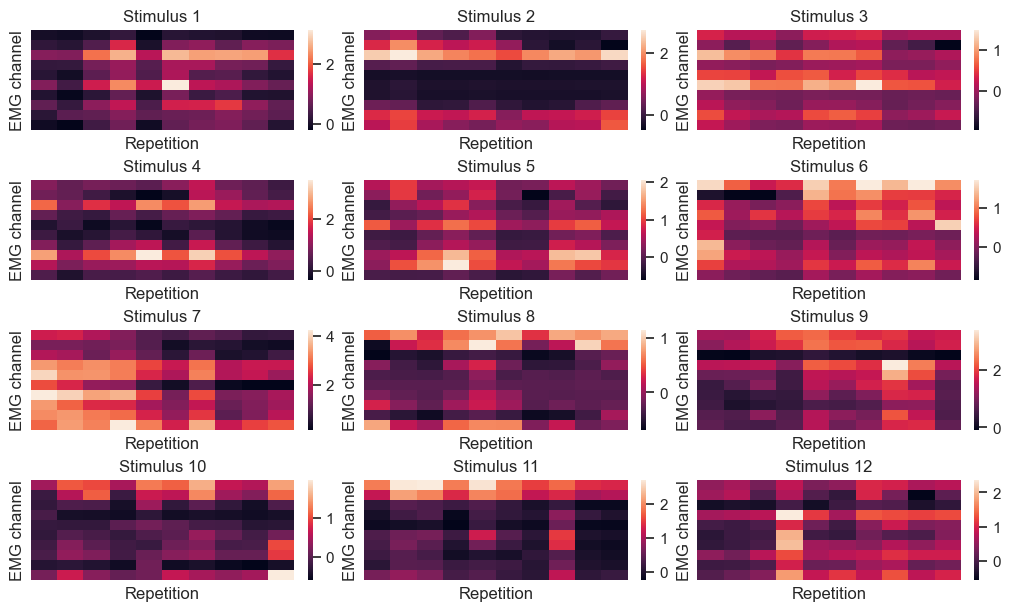

In [206]:
# TODO avoid code duplication
fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout = True, sharex=True, sharey=True)
ax = ax.ravel()
for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(n_emg_average_activations[:, stimuli_idx, :]), ax = ax[stimuli_idx], xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

**Question:** 

Does the data look reasonable? Did you need to remove any trials?

**Answer:** 

...

# Split the data into training, validation, and testing sets

In [207]:
# Assuming 'data' and 'labels' are already loaded and preprocessed
labels = stimulus
# Define the split ratios
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# First, split the data into training and temp sets
data_train, data_temp, labels_train, labels_temp = train_test_split(data, labels, test_size=(1 - train_ratio), random_state=42)

# Then, split the temp set into validation and test sets
data_val, data_test, labels_val, labels_test = train_test_split(data_temp, labels_temp, test_size=(test_ratio / (test_ratio + validation_ratio)), random_state=42)


data_info = {
    "Dataset": ["Training", "Validation", "Testing"],
    "Data Shape": [data_train.shape, data_val.shape, data_test.shape],
    "Labels Shape": [labels_train.shape, labels_val.shape, labels_test.shape]
}
df = pd.DataFrame(data_info)
print(df)

      Dataset   Data Shape Labels Shape
0    Training  (70480, 10)   (70480, 1)
1  Validation  (15103, 10)   (15103, 1)
2     Testing  (15103, 10)   (15103, 1)


**Question:** 

Why do we need the different datasets?

**Answer:** 

Different datasets are used to ensure a machine learning model generalizes well to new data. The training set is used to learn and adjust model parameters, the validation set is used to tune hyperparameters and select the best model configuration, and the testing set provides an unbiased evaluation of the final model's performance on unseen data. This approach helps prevent overfitting and ensures the model performs well in real-world applications.

# Extract features from the trials

In [208]:
def build_dataset(emg, stimulus, repetition, features=None):
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    n_samples = n_stimuli * n_repetitions
    n_channels = emg.shape[1]
    n_features = sum(n_channels for feature in features)

    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    print(f'Labels shape {labels.shape} and dataset shape {dataset.shape}')
    print(n_stimuli, ", ", n_repetitions, ", ", n_samples, ", ", n_channels, ", ", n_features)

    current_sample_index = 0

    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            labels[current_sample_index] = i + 1
            # (f"Labels[{current_sample_index}] = ", labels[current_sample_index])
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()

            current_feature_index = 0
            for feature in features:
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                
                # Compute the feature and aggregate if necessary
                feature_values = feature(emg[selected_tsteps, :])
                if feature_values.shape[0] != n_channels:
                    feature_values = np.mean(feature_values, axis=0)  # Example: mean aggregation
                
                # Assign features to the current sample
                dataset[current_sample_index, selected_features] = feature_values
                current_feature_index += n_channels
            
            current_sample_index += 1

    print(labels)
    return dataset, labels


In [235]:
# Feature definition
# # Mean Absolute Value
# mav = lambda x: np.mean(np.abs(x), axis=0)

# # Standard Deviation
# std = lambda x: np.std(x, axis=0)

# # Maximum Absolute Value
# maxav = lambda x: np.max(np.abs(x), axis=0)

# # Root Mean Square
# rms = lambda x: np.sqrt(np.mean(x**2, axis=0))

# # Waveform Length 
# wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)

def mav(x):
    return np.mean(np.abs(x), axis=0)

def std(x):
    return np.std(x, axis=0)

def maxav(x):
    return np.max(np.abs(x), axis=0)

def rms(x):
    return np.sqrt(np.mean(x**2, axis=0))

def wl(x):
    return np.sum(np.abs(np.diff(x, axis=0)), axis=0)

# Slope Sign Change 
def ssc(x):
    """
    Computes the Slope Sign Change (SSC) feature.
    Parameters:
        x: 2D array-like, where rows represent time steps and columns are channels
    Returns:
        Array of SSC values for each channel
    """
    diff1 = np.diff(x, axis=0)
    diff2 = np.sign(diff1)
    ssc_values = np.sum((diff2[1:] != diff2[:-1]), axis=0)
    return ssc_values

# TODO add other features (two papers in the exercises of W11)

In [236]:
features = [mav]
features = [mav, std, maxav, rms, wl, ssc]

dataset, labels = build_dataset(
    emg = data,
    stimulus = stimulus,
    repetition = repetition,
    features = features
)
print(f'dataset dimension is {dataset.shape} and labels dimension is {labels.shape} ')
print(labels)
print(dataset)


Labels shape (120,) and dataset shape (120, 60)
12 ,  10 ,  120 ,  10 ,  60
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  6.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 11. 11. 11. 11. 11. 11. 11. 11.
 11. 11. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.]
dataset dimension is (120, 60) and labels dimension is (120,) 
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  6.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.
 10. 10.

In [237]:
def summarize_features(dataset, n_channels, features):
    n_features = len(features)
    print(n_features)
    feature_summary = {}

    for i, feature_func in enumerate(features):
        print(f'i: {i}, and feature: {feature_func.__name__}')
        feature_name = feature_func.__name__
        for ch in range(n_channels):
            feature_values = dataset[:, i * n_channels + ch]  # Extract feature for channel
            feature_summary[f"{feature_name}_ch{ch+1}"] = {
                "mean": np.mean(feature_values),
                "std": np.std(feature_values),
                "median": np.median(feature_values),
                "range": np.max(feature_values) - np.min(feature_values),
            }

    # Convert to DataFrame for better visualization
    return pd.DataFrame(feature_summary).transpose()

# Example usage:
summary = summarize_features(dataset, n_channels=10, features=[mav, std, maxav, rms, wl, ssc])
print(summary)


6
i: 0, and feature: mav
i: 1, and feature: std
i: 2, and feature: maxav
i: 3, and feature: rms
i: 4, and feature: wl
i: 5, and feature: ssc
                  mean        std      median       range
mav_ch1       0.785619   0.319152    0.720820    1.347958
mav_ch2       0.508316   0.222100    0.507323    0.985073
mav_ch3       0.284548   0.189338    0.228013    0.687786
mav_ch4       0.241694   0.203585    0.173659    0.840331
mav_ch5       0.032901   0.033332    0.023009    0.161343
mav_ch6       0.011273   0.009858    0.007454    0.046344
mav_ch7       0.023714   0.025617    0.015893    0.130674
mav_ch8       0.357725   0.246968    0.271390    1.104138
mav_ch9       0.656261   0.392311    0.628614    1.923088
mav_ch10      0.194577   0.157138    0.151082    0.808476
std_ch1       0.334891   0.155506    0.334517    0.785465
std_ch2       0.204156   0.080203    0.199339    0.433030
std_ch3       0.130233   0.075632    0.118878    0.334223
std_ch4       0.156042   0.129630    0.119502  

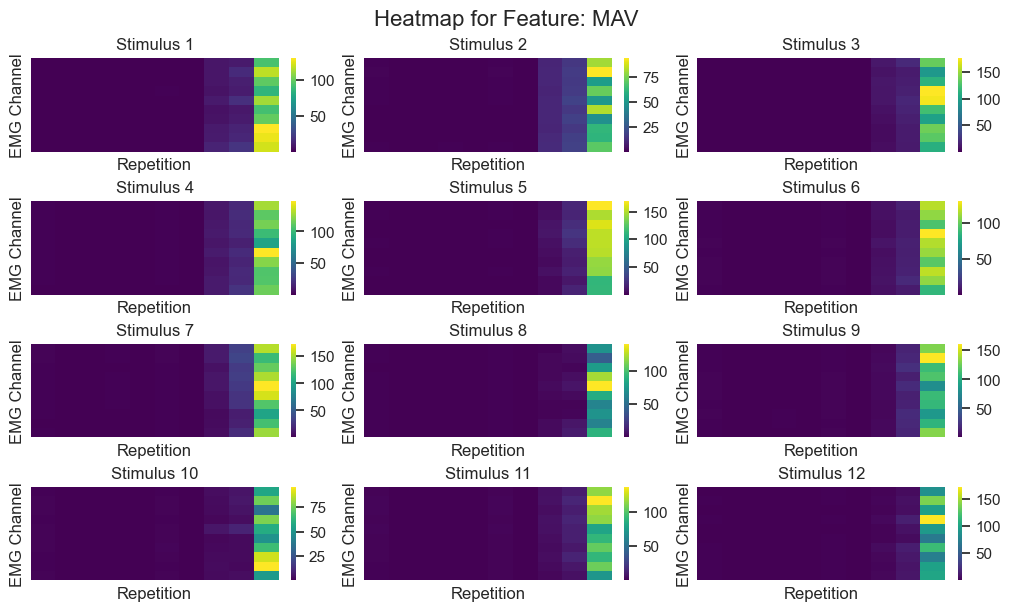

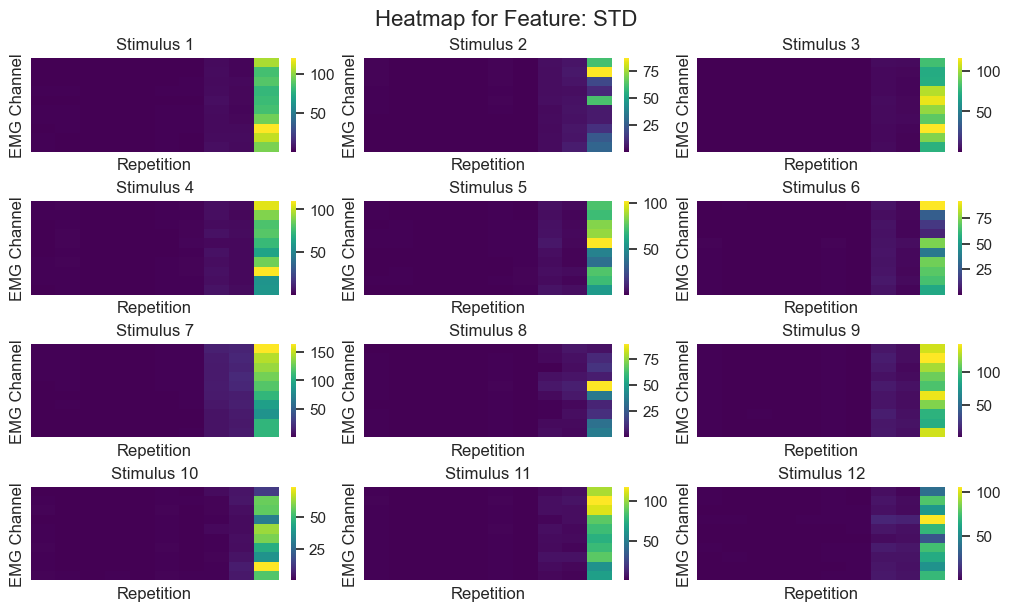

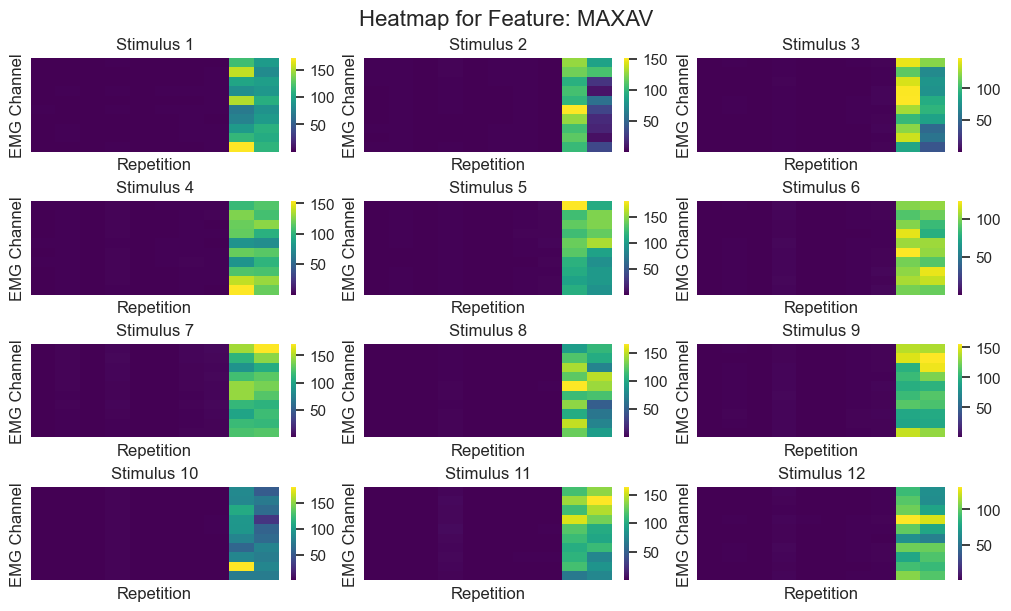

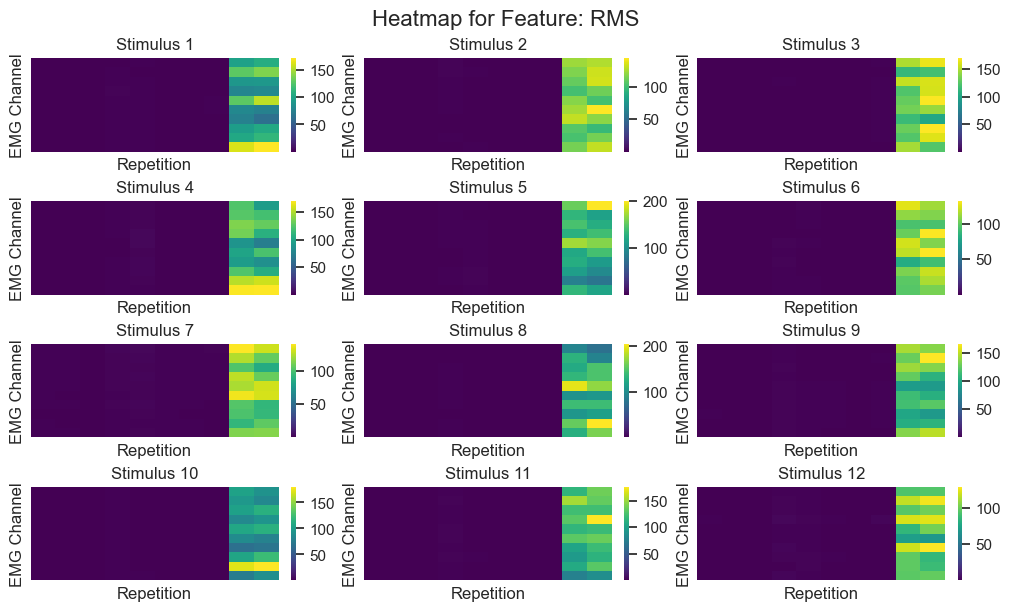

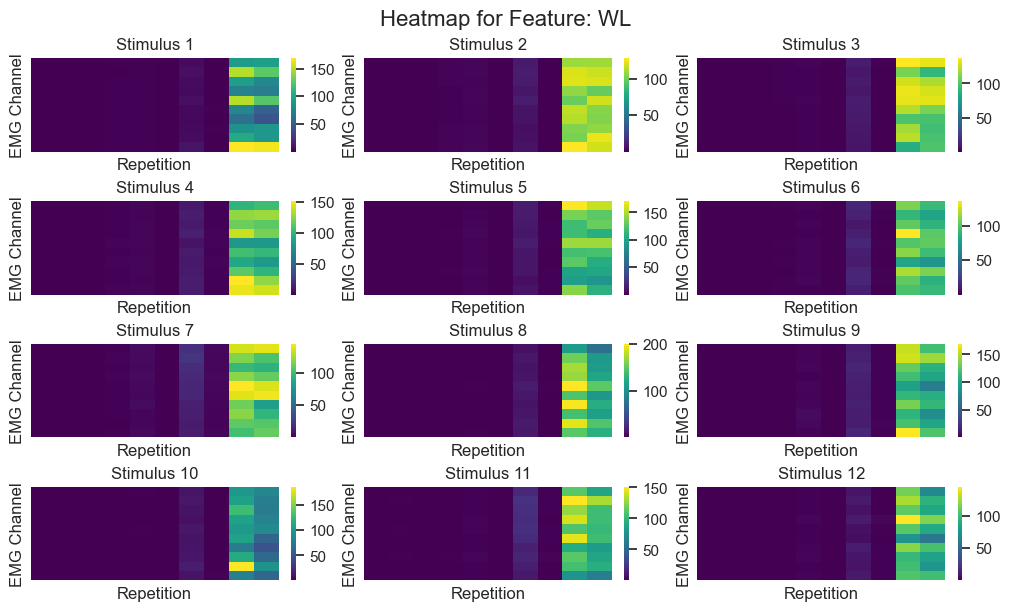

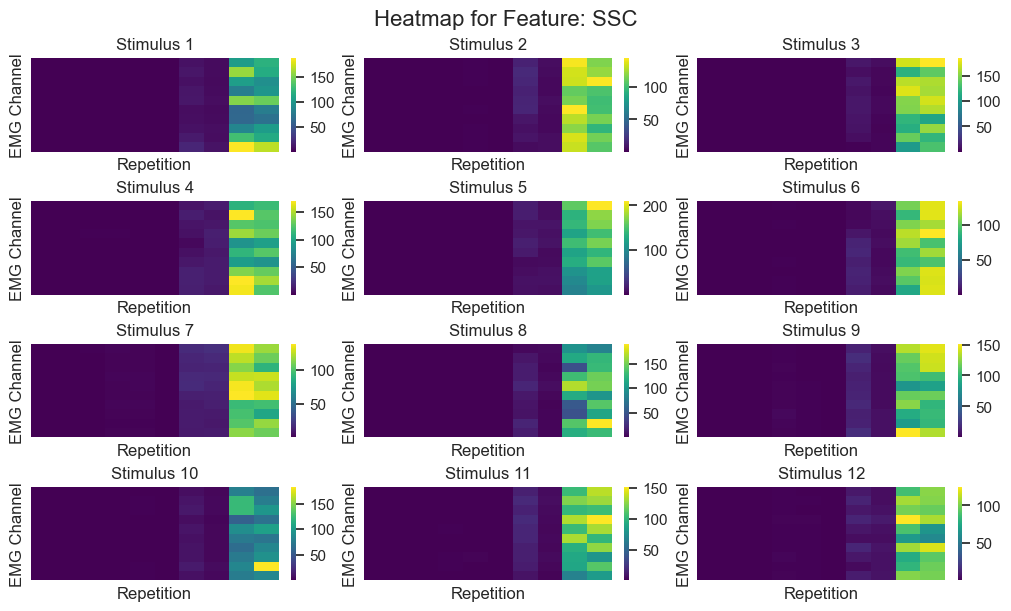

In [241]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape dataset for plotting (assuming 120 samples, 10 channels, 6 features)
n_samples, n_features = dataset.shape
n_channels = 10
n_features_per_channel = n_features // n_channels  # Should be 6 in this case

# Reshape dataset into (n_samples, n_channels, n_features_per_channel)
reshaped_dataset = dataset.reshape(n_samples, n_channels, n_features_per_channel)

feature_names = ["MAV", "STD", "MAXAV", "RMS", "WL", "SSC"]

# Plot heatmaps for each feature across stimuli
for feature_idx, feature_name in enumerate(feature_names):
    feature_data = reshaped_dataset[:, :, feature_idx]  # Shape (120, 10)
    
    # Reshape to (n_stimuli, n_repetitions, n_channels)
    n_stimuli = len(np.unique(labels)) 
    n_repetitions = n_samples // n_stimuli
    feature_data = feature_data.reshape(n_stimuli, n_repetitions, n_channels)
    
    fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
    ax = ax.ravel()

    for stimuli_idx in range(n_stimuli):
        sns.heatmap(
            np.squeeze(feature_data[stimuli_idx, :, :]), 
            ax=ax[stimuli_idx],
            xticklabels=False,
            yticklabels=False,
            cbar=True,
            cmap="viridis"
        )
        ax[stimuli_idx].title.set_text(f"Stimulus {stimuli_idx + 1}")
        ax[stimuli_idx].set_xlabel("Repetition")
        ax[stimuli_idx].set_ylabel("EMG Channel")

    fig.suptitle(f"Heatmap for Feature: {feature_name}", fontsize=16)
    plt.show()


- Homogeneity across channels
- Heterogeneity across repetitions
- Variability across stimuli

# Classification
We perform the same preprocessing, but with the data of subject 1.

In [245]:
# Load and Extract Data

# Define the path to the zip file and the extraction directory
zip_file_path = '../data/s1.zip'
extraction_dir = '../data/'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

# Define the paths to the .mat files
mat_file_path = os.path.join(extraction_dir, 'S1_A1_E1.mat')
mat_file_path_e2 = os.path.join(extraction_dir, 'S1_A1_E2.mat')
mat_file_path_e3 = os.path.join(extraction_dir, 'S1_A1_E3.mat')

# Delete the S1_A1_E2.mat and S1_A1_E3.mat files
if os.path.exists(mat_file_path_e2):
    os.remove(mat_file_path_e2)
if os.path.exists(mat_file_path_e3):
    os.remove(mat_file_path_e3)

# Load the .mat file using scipy.io.loadmat
mat_data = loadmat(mat_file_path)

# Extract the data and labels
data = mat_data['emg']
stimulus = mat_data['restimulus'] # Type of movement that is being performed
repetition = mat_data['rerepetition'] # Number of times the movement has been repeated

print(f'EMG data dimension: {data.shape}')

EMG data dimension: (101014, 10)


In [247]:
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

# For each trial, we create a nested list of envelopes of the trials
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx  =np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = data[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0)

## Train-test-validation split

In [249]:
# Assuming 'data' and 'labels' are already loaded and preprocessed
labels = stimulus
# Define the split ratios
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# First, split the data into training and temp sets
data_train, data_temp, labels_train, labels_temp = train_test_split(data, labels, test_size=(1 - train_ratio), random_state=42)

# Then, split the temp set into validation and test sets
data_val, data_test, labels_val, labels_test = train_test_split(data_temp, labels_temp, test_size=(test_ratio / (test_ratio + validation_ratio)), random_state=42)


data_info = {
    "Dataset": ["Training", "Validation", "Testing"],
    "Data Shape": [data_train.shape, data_val.shape, data_test.shape],
    "Labels Shape": [labels_train.shape, labels_val.shape, labels_test.shape]
}
df = pd.DataFrame(data_info)
print(df)

      Dataset   Data Shape Labels Shape
0    Training  (70709, 10)   (70709, 1)
1  Validation  (15152, 10)   (15152, 1)
2     Testing  (15153, 10)   (15153, 1)


## Feature definition

In [250]:
features = [mav]
features = [mav, std, maxav, rms, wl, ssc]

dataset, labels = build_dataset(
    emg = data,
    stimulus = stimulus,
    repetition = repetition,
    features = features
)
print(f'dataset dimension is {dataset.shape} and labels dimension is {labels.shape} ')
print(labels)
print(dataset)

Labels shape (120,) and dataset shape (120, 60)
12 ,  10 ,  120 ,  10 ,  60
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  6.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 11. 11. 11. 11. 11. 11. 11. 11.
 11. 11. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.]
dataset dimension is (120, 60) and labels dimension is (120,) 
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  6.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.
 10. 10.

## Random forest

## Hyperparameter optimization

### Look at the typical values of the features across the different trials

In [211]:
from functions import *

# Print the shape of the data
print("Data shape:", data.shape)

# Define the number of samples per trial
samples_per_trial = 1000
data_reshaped = reshape_data(data, samples_per_trial)

# Print the shape of the reshaped data
print("Reshaped data shape:", data_reshaped.shape)

# Extract features from the reshaped data
features = extract_features_from_data(data_reshaped)

# Print the shape of the extracted features
print("Extracted features shape:", features.shape)

Data shape: (100686, 10)
Reshaped data shape: (100, 1000, 10)
Extracted features shape: (100, 60)


            MAV_1      MAVS_1       RMS_1   ZC_1        WL_1       SSC_1  \
count  100.000000  100.000000  100.000000  100.0  100.000000  100.000000   
mean     0.396425    0.019263    0.565682    0.0   19.243560  339.670000   
std      0.157975    0.005775    0.220357    0.0    5.769509   44.202028   
min      0.135604    0.008507    0.204337    0.0    8.498200  157.000000   
25%      0.290138    0.015362    0.426841    0.0   15.346325  329.000000   
50%      0.363891    0.018121    0.521692    0.0   18.102750  347.500000   
75%      0.464676    0.021917    0.674336    0.0   21.895000  368.500000   
max      0.984285    0.040275    1.238848    0.0   40.234900  396.000000   

            MAV_2      MAVS_2       RMS_2   ZC_2  ...       RMS_9        ZC_9  \
count  100.000000  100.000000  100.000000  100.0  ...  100.000000  100.000000   
mean     0.326241    0.025456    0.410408    0.0  ...    0.510220    0.060000   
std      0.159717    0.010139    0.162928    0.0  ...    0.288645    0.3

C:\Users\eva\AppData\Local\Temp\ipykernel_48440\708117549.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_channels)
C:\Users\eva\AppData\Local\Temp\ipykernel_48440\708117549.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.errorbar(indices, summary_stats.loc['mean'][indices], yerr=summary_stats.loc['std'][indices], fmt='o', ecolor=colors(i), capsize=5, label=f'Channel {i+1}')


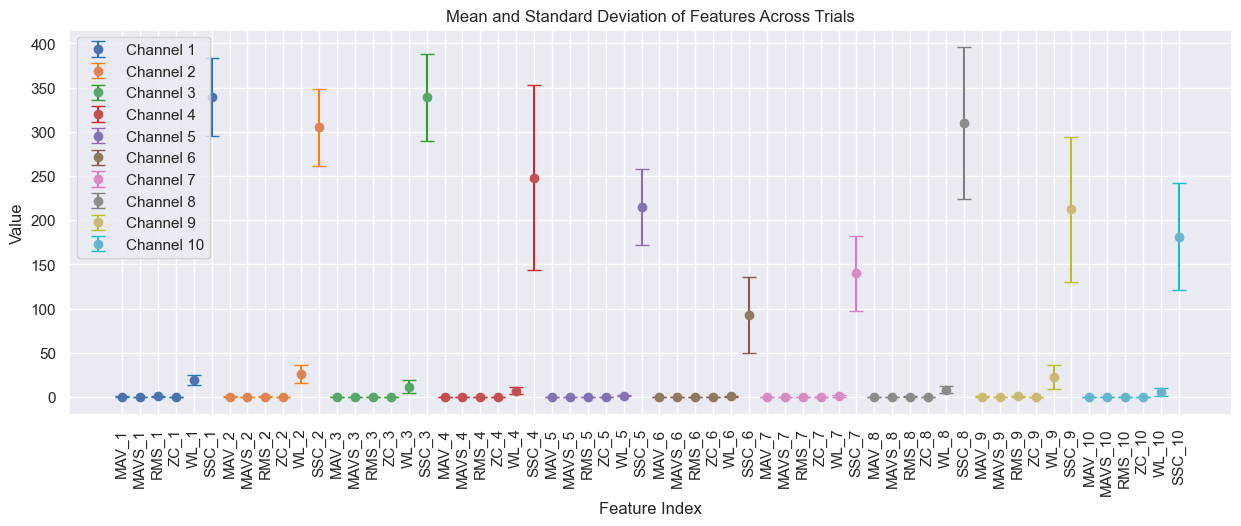

C:\Users\eva\AppData\Local\Temp\ipykernel_48440\708117549.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.errorbar(j, summary_stats.loc['mean'][index], yerr=summary_stats.loc['std'][index], fmt='o', ecolor=colors(j), capsize=5, label=f'Channel {j+1}' if i == 0 else "")
C:\Users\eva\AppData\Local\Temp\ipykernel_48440\708117549.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.errorbar(j, summary_stats.loc['mean'][index], yerr=summary_stats.loc['std'][index], fmt='o', ecolor=colors(j), capsize=5, label=f'Channel {j+1}' if i == 0 else "")
C:\Users\eva\AppData\Local\Temp\ipykernel_48440\708117549.py:42: Fut

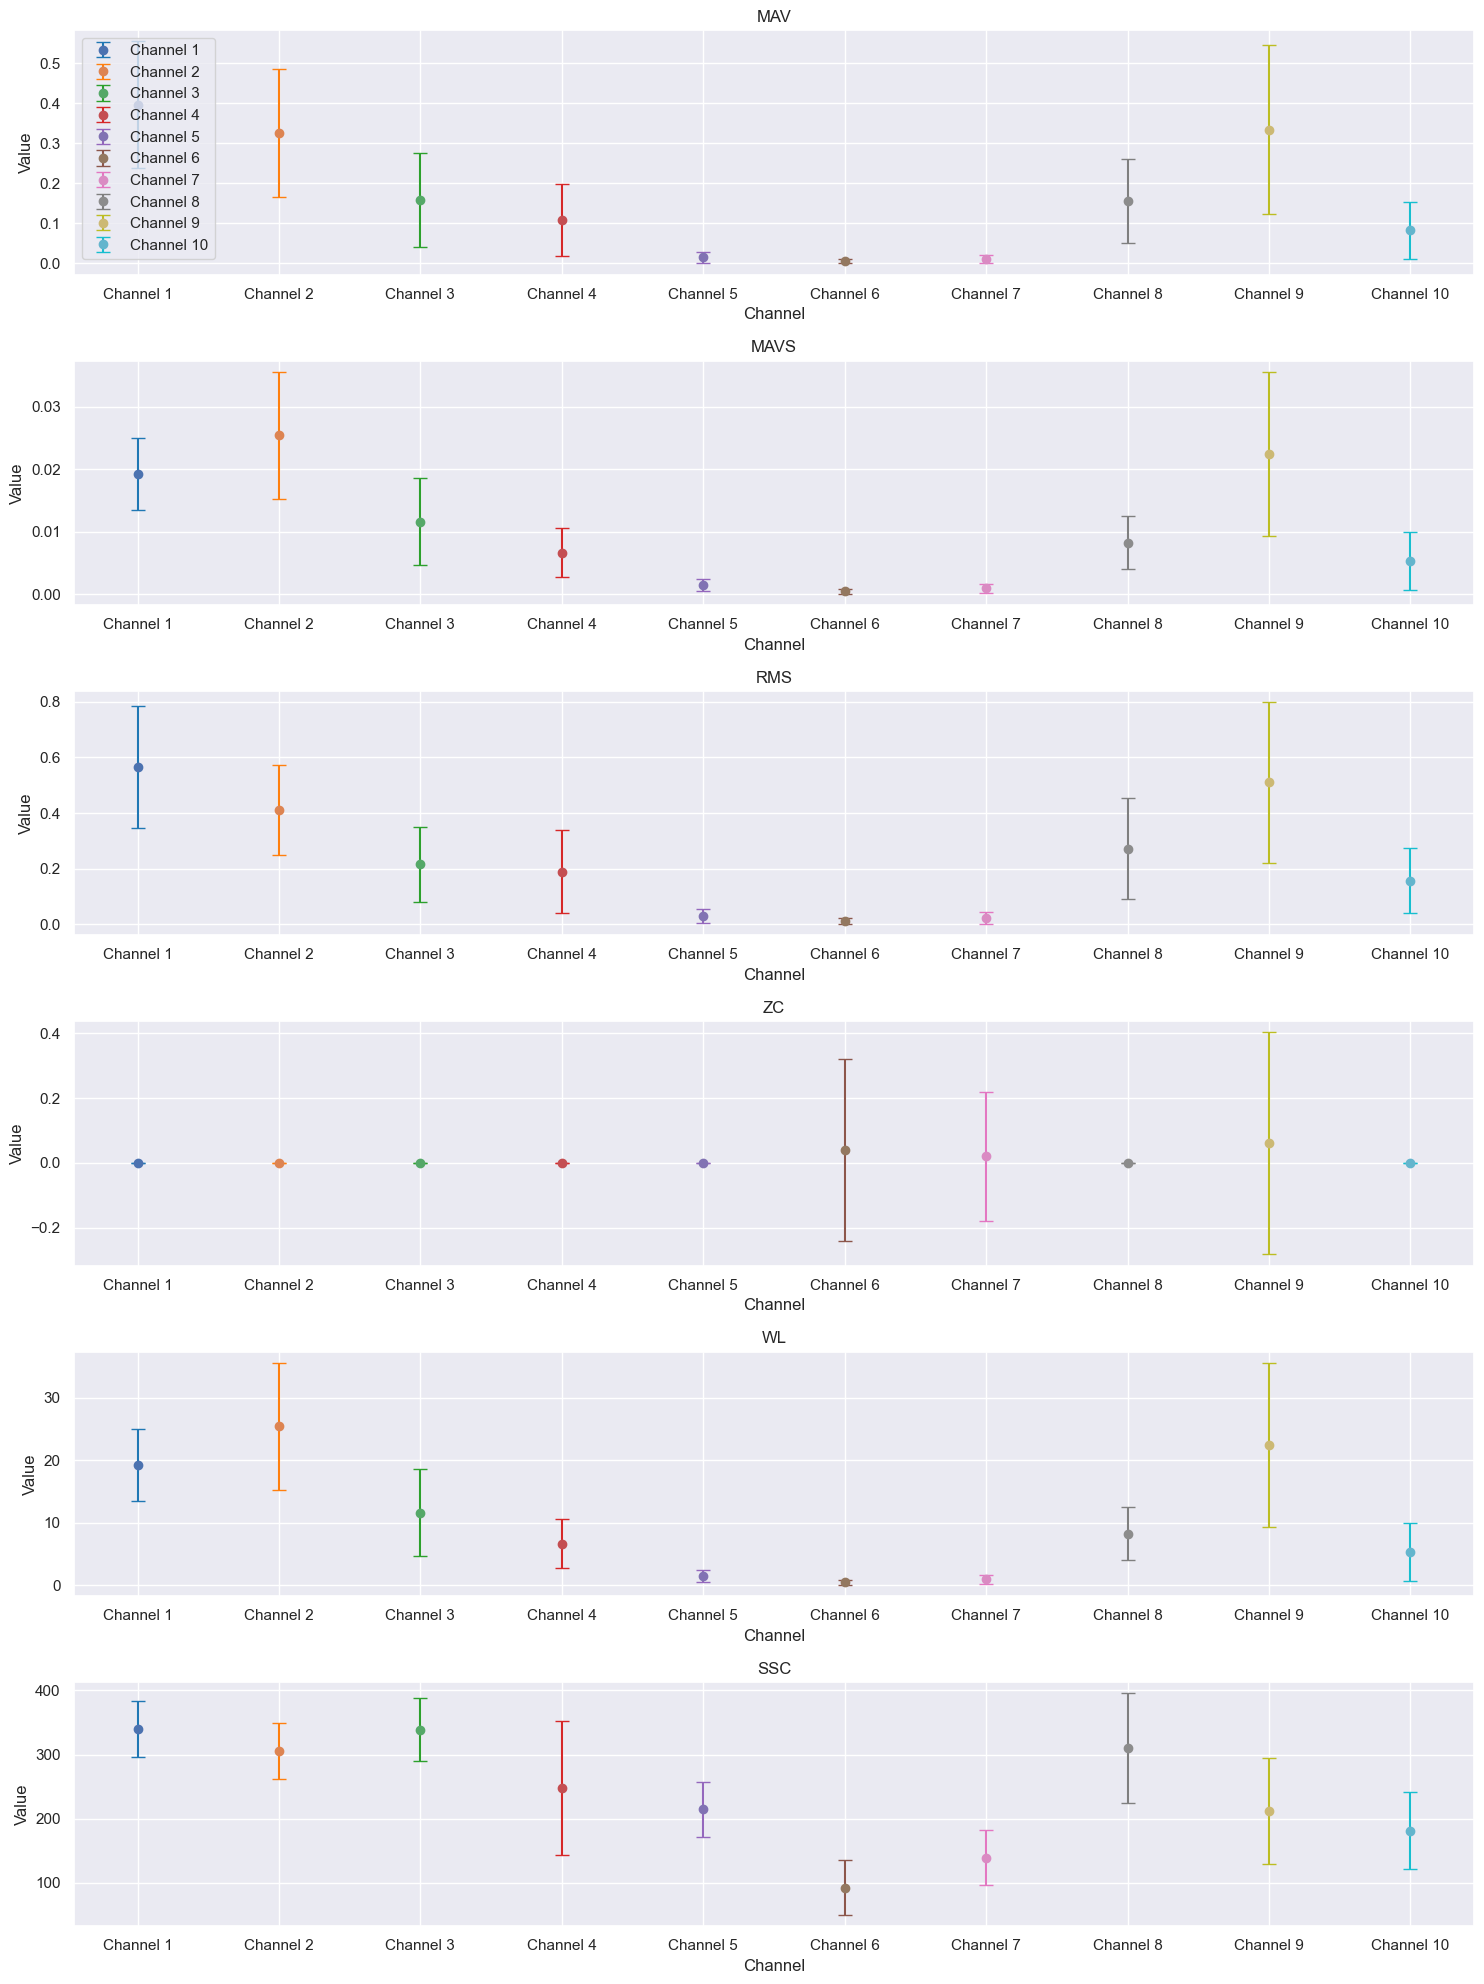

In [212]:
# Assuming 'features' is the matrix of extracted features with shape (num_trials, num_features)
num_trials, num_features = features.shape
num_channels = num_features // 6

# Generate feature names
feature_names = []
for i in range(num_channels):
    feature_names.extend([
        f'MAV_{i+1}', f'MAVS_{i+1}', f'RMS_{i+1}', f'ZC_{i+1}', f'WL_{i+1}', f'SSC_{i+1}'
    ])

# Convert the features matrix to a DataFrame for easier analysis
features_df = pd.DataFrame(features, columns=feature_names)

# Compute and print summary statistics
summary_stats = features_df.describe()
print(summary_stats)

# Define a color map
colors = plt.cm.get_cmap('tab10', num_channels)

# Plot the mean and standard deviation of each feature
plt.figure(figsize=(15, 5))
for i in range(num_channels):
    indices = range(i * 6, (i + 1) * 6)
    plt.errorbar(indices, summary_stats.loc['mean'][indices], yerr=summary_stats.loc['std'][indices], fmt='o', ecolor=colors(i), capsize=5, label=f'Channel {i+1}')
plt.title('Mean and Standard Deviation of Features Across Trials')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.xticks(ticks=range(num_features), labels=feature_names, rotation=90)
plt.legend(loc='upper left')
plt.show()

# Plot the mean and standard deviation of each feature
fig, axes = plt.subplots(6, 1, figsize=(15, 20))
feature_types = ['MAV', 'MAVS', 'RMS', 'ZC', 'WL', 'SSC']

for i, feature_type in enumerate(feature_types):
    ax = axes[i]
    for j in range(num_channels):
        index = i + j * 6
        ax.errorbar(j, summary_stats.loc['mean'][index], yerr=summary_stats.loc['std'][index], fmt='o', ecolor=colors(j), capsize=5, label=f'Channel {j+1}' if i == 0 else "")
    ax.set_title(f'{feature_type}')
    ax.set_xlabel('Channel')
    ax.set_ylabel('Value')
    ax.set_xticks(range(num_channels))
    ax.set_xticklabels([f'Channel {j+1}' for j in range(num_channels)])
    if i == 0:
        ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

**Question:** 

What do you see? Are the values similar between repetitions and between channels? Explain the possible reasons for similarity/discrepancies.

**Answer:** 

In most channels, we know that the values are similar between repetitions because the mean values of the features for each channel have relatively small standard deviations, as shown by the error bars in the plots, indicating a stable and repeatable EMG signals for the same movements. 

However, there are noticeable differences in feature values between channels. These discrepancies can be attributed to factors such as variations in electrode placement, differences in muscle activation, and varying levels of signal noise, highlighting the impact of physiological and technical factors on EMG signal characteristics.

### Perform classification on the data (Random Forest)